<a href="https://colab.research.google.com/github/ybc1991/Cirq/blob/forrelation/docs/tutorials/fourier_checking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import cirq
except:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")
    import cirq

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(precision=3, suppress=True, linewidth=200)

# Introduction


In past decades, there is ample evidence suggesting that quantum computers can be exponentially more powerful in solving certain computational tasks than their classical couterparts. The *black-box* or *query* model, such as Grover’s search, Deutsch-Jozsa’s algorithm, etc., offers a concrete setting to show such exponential speedups. Normally, one provides "black-box access" to a function $f$, meaning that the quantum algorithm can apply a unitary
transformation that maps basis states of the form $|x, y \rangle$ to to basis states of the form $|x, y \oplus f(x)\rangle $ or $|x\rangle$ to $(-1)^{f(x)} |x\rangle$ if $f$ is Boolean. Then, a natural question is asked:

> What is the maximal possible separation between quantum and classical query complexities?

For example, could there be a function of $N$ bits with a quantum query
complexity of 1, but a classical randomized query complexity of $\Omega(\sqrt{N})$ or $\Omega(N)$?
Specifically, [Buhrman et al. from 2002](https://www.sciencedirect.com/science/article/pii/S030439750100144X) asked whether there is any
property of $N-$bit strings that exhibits a **“maximal”** separation: that is, one that requires $\Omega(N)$
queries to test classically, but only O (1) quantumly.

**Fourier Checking** is a problem that provides a separation between quantum  and classical computers -- $O(1)$ VS $\tilde{\Omega}(\sqrt{N})$, which can be proved as optimal. Currently it only has theoretical importance - but, as it falls into the category of small quantum algorithms, it can be used to demonstrate query complexity and oracle synthesis in Cirq.

Goal of this notebook is to introduce

1. What is Forrelation and the Fourier Checking problem and why we are interested in it?
2. What is bounded-error quantum polynomial time (BQP) and why does the Fourier Checking problem belong to it?
3. How to implement Fourier Checking algorithm and Oracle Function in Cirq?

We don't include the formal proofs and argument. But we do give some derivation sketch for intuition and encourage the reader to check the corresponding lemmas and theorems in the original paper.

<!-- ## Structure of this notebook

  We start by reviewing Fourier transform and correlation. Then introduce the concept of *forrelation*, i.e. fourier + correlation. After these preparation,  the formal statement of the *Fourier Checking* problem is presented. Then we solve this problem in a straightforward way, which follows directly from the problem definition. We will use this solution to verify our quantum solution in the next part. During the Cirq implemention, we will discuss the relation between the oracle function and diagonal matrix gate and how you can implemention that in Cirq. Last, we will show this problem provides maximum separation between classical and quantum computers.  -->


# Preliminary

Before we present the Fourier Checking problem, three preliminary concepts, 1) BPP and BQP 2) Fourier Transform over $Z_2^n$ and 3) Forrelation, are introduced first.


## Bounded-error Probabilistic Polynomial time (BPP)

In computational complexity theory, [bounded-error probabilistic polynomial time (BPP)](https://en.wikipedia.org/wiki/BPP_(complexity)) is the class of decision problems solvable by a [probabilistic Turing machine](https://en.wikipedia.org/wiki/Probabilistic_Turing_machine) in polynomial time with an error probability bounded away from 1/3 for all instances:

| &nbsp; &nbsp;&nbsp;&nbsp;&nbsp; Anwser Provided  <br />  <br /> Correct Anwser| Yes <br /> <br /> &nbsp; | No <br /> <br /> &nbsp;|
|:---------------|------|-------|
| Yes           | $\geq$ 2/3 | $\leq$ 1/3 |
| No            | $\leq$ 1/3 | $\geq$ 2/3 |

The choice of 1/3 in the definition is arbitrary. It can be any constant between 0 and ​1/2 (exclusive) and the set BPP will be unchanged.

<!-- 
**Problem**: Supposing we have two qubits and we are promised that the two qubits are either in uniform superposition state, $\frac{1}{2}(|00\rangle + |01\rangle + |10\rangle + |11\rangle)$, or Bell state, $\frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$ . The problem is to accept it if it was in Bell Sate otherwise reject it.

**Naive Algorithm**: Measure two qubits and accept the result if the XOR of two measurements is 0. It is easy to get following confusion matrix:

| Naive Algorithm:  | Accept  | Reject |
|---------------|---------|-------|
| Bell state    | 1   | 0  |
| Uniform State | 1/2 | 1/2|

You see $1/2$ is not larger than $2/3$. So this naive algorithm does **NOT** solve the problem. 

**One Possible Algorithm**: Accept the results if the XOR of two measurements is 0 AND a random number drawing from  $[0,1]$ uniformly is equal or larger than $1/3$. Otherwise, reject it.

At first glance, you may feel this algorithm is worse than the previous one. But you will find it actually solves the problem and satisfies the BQP requirement if you compute the confusion matrix:

| Algorithm:  | Accept  | Reject |
|---------------|---------|-------|
| Bell state    | 2/3 | 1/3  |
| Uniform State | 1/3 | 2/3  |

You can use probability theorem to calculate above confusion matrix exactly but let use Cirq to do simulation to verify that. -->

To understand this better, let's consider a simple example.

**Problem**: Supposing we have a boolean function $f: \{0, 1\}^n \rightarrow\{-1, 1\}$. The function is drawn either from distribution $\mathcal{B}$ or $\mathcal{C}$. Under the distribution $\mathcal{B}$, the function $f$ is balanced, i.e., $\sum_{x} f(x) = 0$. Under the distribution $\mathcal{C}$, the function $f$ is constant, i.e., function is always equal to $+1$ or $-1$. The problem is to accept the function if it is drawn from $\mathcal{B}$ or reject it otherwise.

For example, consider the case that $n=2$. There are only four possible functions listed in following table

|x   | f_0(x)| f_1(x)| f_2(x)| f_3(x)|
|----|----:|----:|----:|----:|
| 0  | +1 | -1 | +1 | -1 |
| 1  | -1 | +1 | +1 | -1 |

Clearly, $f_0$ and $f_1$ belongs to $\mathcal{B}$ and $f_2$ and $f_3$ belongs to $\mathcal{C}$.

**Deterministic Algorithm**:  We evaluate the outputs of function of $2^{n-1}+1$ different inputs. If the results contain both $+1$ and $-1$ value, the function must be drawn from distribution $\mathcal{B}$. Otherwise, it must come from $\mathcal{C}$.

Remembering that the function is guaranteed to be either balanced or constant, not somewhere in between. So above algorithm is guaranteed to be always correct. However, the query complexity is $O(N)$, denoting $N=2^n$. Here we are interested in the query complexity instead of computation complexity. Namely, how many times we have to evaluate $f$ -- which you can imagine being a very costly function. If the bounded-error probability is acceptable for solving the problem, we can achieve better algorithm in terms of query complexity.

**Randomized Algorithm**: Randomly select $K$ different inputs and evaluate the corresponding outputs. If both $+1$ and $-1$ are observed, we accept it. Otherwise, it reject it.

The complexity of algorithm depends on the choice of $K$. For this problem, selecting fixed number is sufficient, i.e. $O(1)$ query complexity. It is worth to remark that $O(1)$ means no matter the fixed number is independent of the input size of function $N$. Consider the $K=2$ case, it is not hard to establish the following confusion matrix regardless of $N$:

| Randomized Algorithm (K=2):  | Accept  | Reject |
|---------------|---------|-------|
| Drawn from $\mathcal{B}$ | 1/2 | 1/2  |
| Drawn from $\mathcal{C}$ | 0 | 1 |

This is not sufficient to solve it. However, if we select $K>2$ entries, the  probability of correctness will boost. Let's use the code to exam it.

In [2]:
def gen_balanced_function(N):
    half_size = N // 2
    f = np.ones(N)
    flip_loc = np.random.permutation(N)[:half_size]
    f[flip_loc] = -1
    return f


def gen_constant_function(N):
    flip = np.random.random() > 0.5
    f = np.ones(N) if flip else -1 * np.ones(N)
    return f

In [3]:
def randomized_alg(f, sample_size):
    N = len(f)
    sample_index = np.random.choice(N, size=sample_size)
    if len(set(f[sample_index])) == 2:
        return "accept"
    return "reject"

In [4]:
N = 128
K = 3

res = pd.DataFrame()
for _ in range(1000):
    if np.random.rand() > 0.5:
        f = gen_balanced_function(N)
        dist = "B"
    else:
        f = gen_constant_function(N)
        dist = "C"
    decision = randomized_alg(f, K)
    res = res.append({
        "Distribution": dist,
        "Decision": decision,
        "Count": 1
    }, ignore_index=True)
confusion = res.pivot_table(index="Distribution",
                            columns="Decision",
                            values="Count",
                            aggfunc="sum")
# Translate the counts into percentage
confusion.div(confusion.sum(axis=1), axis=0).apply(lambda x: round(x, 4) * 100)

Decision,accept,reject
Distribution,,
B,77.0,23.0
C,NaN,100.0


Recall that the B in BPP means *bounded-error*. Actually, you can achieve arbitary small error rate under the same query complexity order. Say, you set an acceptable error rate $\epsilon$. Then the key is that we can run the algorithm multiple times. Repeat it as many times as you want until the error rate is lower than $\epsilon$. It is crucial to note that the error rate for this particular problem does not depend on the size of the input but only on the size of the sample and the reptitation. For this reason, in order to get to a bounded probability error, it is sufficient to just adjust the sample size and/or repetitions to a given constant - which means that the "query complexity" of the algorithm will stay $O(1)$. For example, let's run previous algorithms 3 times and make the final decision based on the majority of the decision of each term. You should verify that the probability of error indeed decreased and independent of $N$.

In [5]:
N = 128
K = 3
repetitions = 3

res = pd.DataFrame()
for _ in range(1000):
    if np.random.rand() > 0.5:
        f = gen_balanced_function(N)
        dist = "B"
    else:
        f = gen_constant_function(N)
        dist = "C"
    accept_minus_reject_count = 0
    for _ in range(repetitions):
        decision = randomized_alg(f, K)
        accept_minus_reject_count += 1 if decision == "accept" else -1
    final_decision = "accept" if accept_minus_reject_count > 0 else "reject"
    res = res.append(
        {
            "Distribution": dist,
            "Decision": final_decision,
            "Count": 1
        }, ignore_index=True)
confusion = res.pivot_table(index="Distribution",
                            columns="Decision",
                            values="Count",
                            aggfunc="sum")
# Translate the counts into percentage
confusion.div(confusion.sum(axis=1), axis=0).apply(lambda x: round(x, 4) * 100)

Decision,accept,reject
Distribution,,
B,84.83,15.17
C,NaN,100.00


If you try the algorithm with more repetitions, you will observe the error rate decreases rapidly. You can also try different values of $K, N, $ and/or repetitions to see how the confusion matrix changes according.

After you understand the concept of BPP, it is easy to understand [bounded-error quantum polynomial time (BQP)](https://en.wikipedia.org/wiki/BQP) now. BQP is the class of decision problems solvable by a quantum computer in polynomial time, with an error probability of at most 1/3 for all instances. It is the quantum analogue to the complexity class BPP. Actually, under quantum computer, previous problem can be solved through [Deutsch–Jozsa algorithm](https://en.wikipedia.org/wiki/Deutsch%E2%80%93Jozsa_algorithm) with a single query while guaranteed to be correct always. The Fourier Checking problem that will be introduced later is belong to BQP as well.

## Fourier Transform over $\mathbb{Z}^n_2$
In this colab, we are interested in the boolean function of the form $f : \{0, 1\}^n \rightarrow\{-1, 1\}$. In this case, the Fourier transform of $f$ over $\mathbb{Z}^n_2$ is defined as
$$
  \hat{f}(y) := \frac{1}{\sqrt{N}} \sum_{x\in\{0,1\}^n} (-1)^{x \cdot y} f
  (x).
$$
where $x \cdot y$ means the bit-wise inner product between $x$ and $y$. Note this is not the standard discrete Fourier transform definition over $\mathbb{Z}_N$. According to the Parseval's identity, we have

$$
  \sum_{x\in\{0,1\}^n} f(x)^2 = \sum_{y\in\{0,1\}^n} \hat{f}(y)^2  = N .
$$

In [6]:
def bitwise_dot(x, y):
    """Compute the dot product of two integers bitwise."""

    # fast bit parity
    def parallel_swar(i):
        i = i - ((i >> 1) & 0x55555555)
        i = (i & 0x33333333) + ((i >> 2) & 0x33333333)
        i = (((i + (i >> 4)) & 0x0F0F0F0F) * 0x01010101) >> 24
        return int(i % 2)

    return parallel_swar(x & y)


def fourier_transform_over_z2(v):
    """Fourier transform function over z_2^n group.

    Args:
        v: an array with 2**n elements.

    Returns:
        vs: a numpy array with same length as input.
    """
    assert len(v) & (len(v) - 1) == 0  # make sure v is 2**n long vector
    N = len(v)
    v_hat = np.array([0.0] * N)
    for y in range(N):
        for x in range(N):
            v_hat[y] += ((-1)**bitwise_dot(x, y)) * v[x]
    return v_hat / np.sqrt(N)

Let's have some examples in $\mathbb{Z}^2_2$. You should verify that both functions have same energy 4.

In [7]:
f = np.array([1, -1, 1, -1])
f_hat = fourier_transform_over_z2(f)
print(f"f: {list(f)} f_hat: {list(f_hat)}")

f = np.array([1, 1, 1, -1])
f_hat = fourier_transform_over_z2(f)
print(f"f: {list(f)} f_hat: {list(f_hat)}")

f = np.array([1, -1, -1, 1])
f_hat = fourier_transform_over_z2(f)
print(f"f: {list(f)} f_hat: {list(f_hat)}")

f: [1, -1, 1, -1] f_hat: [0.0, 2.0, 0.0, 0.0]
f: [1, 1, 1, -1] f_hat: [1.0, 1.0, 1.0, -1.0]
f: [1, -1, -1, 1] f_hat: [0.0, 0.0, 0.0, 2.0]


## Forrelated

The concept of *forrelated* is the key concepts in Fourier checking problem, which is a combination word coming from "Fourier Transform" and "Correlation".
Recall the classical correlation between two vectors $u$ and $v$ is defined as
$$
  {\rm correlation}(u,v) = \frac{ \langle u, v \rangle }{\|u\| \|v\|}.
$$
Then, the forrelation between two vectors $u$ and $v$ is just the correlation between $u$ and the Fourier trasformed of $v$ -- denoted as $\widehat{v}$:
\begin{align}
  {\rm forrelation}(u, v) =& \frac{\langle u, \widehat{v} \rangle }{\|u\| \|\widehat{v}\|},\\
  =& \frac{ \langle u, \widehat{v} \rangle }{\|u\| \|v\|}.
\end{align}
where the second equality is due to the Parseval's identity.
Since in this tutorial we are interesed in Boolean function, we replace the arbitary vector $u$ and $v$ by the output of Boolean function $f$ and $g$. Now we can further simplify the above definition:
\begin{align}
  {\rm forrelation}(f, g) =& \frac{\langle f, \widehat{g} \rangle }{\|f\| \|g\|}\\
  =& \frac{1}{N} \langle f, \widehat{g}\rangle  \\
  =& \frac{1}{N} \sum_{x \in \{0,1\}^n}f(x)\widehat{g}(x)\\
  =& \frac{1}{N^{3/2}} \sum_{x, y \in \{0,1\}^n}f(x)(-1)^{x \cdot y}g(y)
\end{align}


In [8]:
def get_correlation(f, g):
    return f.dot(g) / np.linalg.norm(f) / np.linalg.norm(g)


def get_forrelation(f, g):
    g_hat = fourier_transform_over_z2(g)
    return f.dot(g_hat) / np.linalg.norm(f) / np.linalg.norm(g)

In [9]:
# let's see some examples to gain some insights of forrelation
f = np.array([1, -1, 1, -1]) 
g = np.array([1, -1, 1, -1])
print(f"Correlation: {get_correlation(f,g)}  Forrelation: {get_forrelation(f,g)}")

f = np.array([1, 1, 1, -1])
g = np.array([-1, -1, -1, 1])
print(f"Correlation: {get_correlation(f,g)}  Forrelation: {get_forrelation(f,g)}")

f = np.array([1, -1, -1, 1])
g = np.array([1, 1, 1, 1])
print(f"Correlation: {get_correlation(f,g)}  Forrelation: {get_forrelation(f,g)}")

Correlation: 1.0  Forrelation: -0.5
Correlation: -1.0  Forrelation: -1.0
Correlation: 0.0  Forrelation: 0.5


# Fourier Checking Problem

Now we are prepared to discuss the *Fourier Checking* problem. Here we are given oracle access to two Boolean functions $f,g : \{0, 1\}^n \rightarrow\{-1, 1\}$. We are promised that one of the following two cases is true:

- $\langle f, g \rangle$ was drawn from the uniform distribution $\mathcal{U}$.
- $\langle f, g \rangle$ was drawn from the forrelated distribution $\mathcal{F}$ (Will be explained in more details later).

The problem is a decision problem that accepts the $\langle f, g \rangle$ if it was drawn from $\mathcal{F}$ and rejects $\langle f, g \rangle$ if it was drawn from $\mathcal{U}$.

*Note: Since $\mathcal{F}$ and $\mathcal{U}$ overlap slightly, we can only hope to succeed with overwhelming probability over the choice of  $\langle f, g \rangle$ , not for every  $\langle f, g \rangle$  pair.*


## Generate functions $f$ and $g$ from distribution $\mathcal U$ and $\mathcal F$
The forrelated distribution $\mathcal{F}$ is generated as followings.
First
choose a random real vector $v=(v_x)_{x\in\{0, 1\}^n} \in \mathbb{R}^N$, by drawing each entry independently from Gaussian distribution with zero-mean and variance 1. Then set $f(x) := {\rm sgn}(v_x)$ and $g(x) := {\rm sgn}(\widehat{v}_x)$, where $\widehat{v}_x$ the Fourier Transform of $v$ is
$$
  \widehat{v}_y := \frac{1}{\sqrt{N}} \sum_{x\in\{0,1\}^n} (-1)^{x\cdot y}v_x,
$$
and $$
  {\rm sgn}(\alpha) := \left\{
  \begin{aligned}
    1 \;\;\; &{\rm if}\; \alpha \geq 0 \\
    -1 \;\;\;&{\rm if}\; \alpha < 0
  \end{aligned}\right.
$$
Notice, $f$ and $g$ *individually* are still uniformly random, but they are no longer independent. Now $f$ is forrelated with $g$.
For simplicity, we only consider the *PROMISE FOURIER CHECKING* problem. Under this situation, we are promised that the quatity:

\begin{align}
  p(f,g) := \left[{\rm forrelation}(f, g)\right]^2 = \frac{1}{N^3} \left(\sum_{x, y \in \{0,1\}^n}f(x)(-1)^{x \cdot y}g(y)\right)^2
\end{align}

is either at least 0.05 or at most 0.01.

In [10]:
n = 6
N = 2 ** n

In [11]:
# We can find a forrelated pair "as promised" through while-loop
def draw_two_distribution_from_f_set(N):
    sgn = lambda x: 1 if x >= 0 else -1
    forrelation = 0.2
    while (abs(forrelation)**2 < 0.05) and (abs(forrelation)**2 > 0.01):
        vs = np.array([np.random.normal() for _ in range(N)])
        vs_hat = fourier_transform_over_z2(vs)
        fs = np.array([sgn(v) for v in vs])
        gs = np.array([sgn(v_hat) for v_hat in vs_hat])
        forrelation = get_forrelation(fs, gs)
        correlation = get_correlation(fs, gs)
    return fs, gs, forrelation, correlation


def draw_two_distribution_from_u_set(N):
    sgn = lambda x: 1 if x >= 0 else -1
    forrelation = 0.2
    while (abs(forrelation)**2 < 0.05) and (abs(forrelation)**2 > 0.01):
        vs = np.array([np.random.normal() for _ in range(N)])
        fs = np.array([sgn(v) for v in vs])
        us = np.array([np.random.normal() for _ in range(N)])
        gs = np.array([sgn(u) for u in us])
        forrelation = get_forrelation(fs, gs)
        correlation = get_correlation(fs, gs)
    return fs, gs, forrelation, correlation

fs: [-1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1]
gs: [-1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1]


Text(0.5, 1.0, 'Correlation: 0.0 Forrelation: 0.015625')

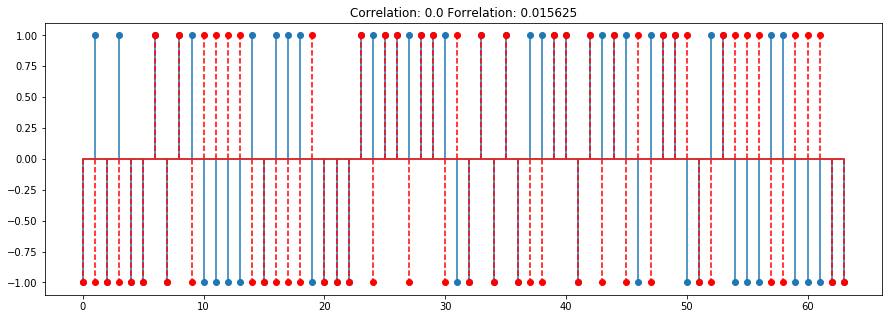

In [12]:
fs, gs, forrelation, correlation = draw_two_distribution_from_u_set(N)
print(f"fs: {list(fs)}")
print(f"gs: {list(gs)}")

plt.figure(figsize=(15, 5))
plt.stem(fs, use_line_collection=True)
plt.stem(gs, linefmt='--r', markerfmt='ro', use_line_collection=True)
plt.title(f"Correlation: {correlation} Forrelation: {forrelation}")

fs: [-1, -1, -1, -1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1]
gs: [1, 1, 1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1]


Text(0.5, 1.0, 'Correlation: -0.09375 Forrelation: 0.5625')

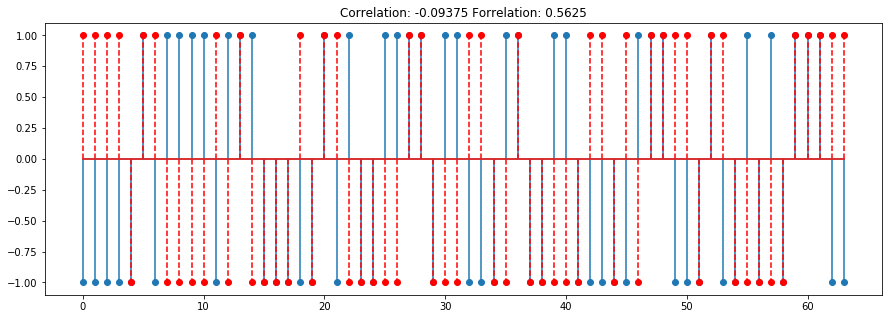

In [13]:
fs, gs, forrelation, correlation = draw_two_distribution_from_f_set(N)
print(f"fs: {list(fs)}")
print(f"gs: {list(gs)}")
plt.figure(figsize=(15, 5))
plt.stem(fs, use_line_collection=True)
plt.stem(gs, linefmt='--r', markerfmt="ro", use_line_collection=True)
plt.title(f"Correlation: {correlation} Forrelation: {forrelation}")

Typically, $\mathcal{U}$ and $\mathcal{F}$ is not obviously different from each other even after we plot the whole functions information together. However, it is not hard to show that Fourier Checking is in BQP: basically, one can prepare a uniform superposition over all $x\in\{0,1\}^n$, then query $f$, apply a quantum Fourier transform, query $g$, and
check whether one has recovered something close to the uniform superposition. On the other hand, being forrelated seems like an extremely “global” property of $f$ and $g$: one that would not be apparent from querying any small number of $f$ and $g$ values, regardless of the outcomes of those queries.

# Quantum Algorithm for Fourier Checking

Now, we present the quantum algorithm for Fourier Checking, which is quite simple actually.
It can achieve the constant error probability with $O(1)$ query complexity.

**Algorithm Description:**

First, we prepare a uniform superposition over all $x \in \{0, 1\}^n$. Then query $f$ in superposition, to create the state
$$
  \frac{1}{\sqrt{N}} \sum_{x \in \{0, 1\}^n} f(x) |x\rangle
$$
Applying Hadmard gates to all $n$ qubits, to create the state
$$
  \frac{1}{N} \sum_{x,y  \in \{0, 1\}^n} f(x) (-1)^{x\cdot y} |y\rangle
$$
Then query $g$ in superposition, to create the state
$$
  \frac{1}{N} \sum_{x,y  \in \{0, 1\}^n} f(x) (-1)^{x\cdot y}g(y) |y\rangle
$$
Then apply Hadmard gates to all $n$ qubits again, to create the state
$$
  \frac{1}{N^{3/2}} \sum_{x,y  \in \{0, 1\}^n} f(x) (-1)^{x\cdot y} g(y) (-1)^{y \cdot z}|z\rangle
$$
Finally, measure in the computational basis, and "accept" if and only if the outcome $|0\rangle^{\otimes n}$is observed.

If needed, repeat the whole algorithm $O(1)$ times to boost the success probability.

It is clear that the probablity of observation $|0\rangle^{\otimes n}$ equals the quantity:
\begin{align}
  p(f,g) := \frac{1}{N^3} \left(\sum_{x, y \in \{0,1\}^n}f(x)(-1)^{x \cdot y}g(y)\right)^2
\end{align}

It is shown in the [paper](https://arxiv.org/pdf/0910.4698.pdf) that

\begin{align}
   {\rm Pr}_{\langle f, g \rangle \sim \mathcal{U}} [p(f,g) \geq 0.01] \leq& \; \frac{100}{N} \\
   {\rm Pr}_{\langle f, g \rangle \sim \mathcal{F}} [p(f,g) \geq 0.05] \geq&\;\frac{1}{50} \\
\end{align}
This implies that the probability of the forrelation square between two functions drawing from uniform  distribution $\mathcal{U}$ having larger than 0.01  will decaying quickly when we have more number of qubits. Hence, the Promise Fourier Checking problem can be solved through simply accepting when $p(f,g) \geq 0.05$ and rejecting when $p(f,g) \leq 0.01$ with constant error probability, using $O(1)$ queries to $f$ and $g$.

## Implementation in Cirq

Above algorithm is simple and straightforward to implement. It only involves with Hadmard gates and function oracles. Implementation of oracles based on truth table in Cirq is just simple diagnal gates. To see that, let's use a oracle defined over $\mathbb{Z}_2^2$ as example:

\begin{align}
  \sum_{x\in \{0, 1\}^2} f(x)|x\rangle
  =&\frac{1}{2}\Big(f(0,0)|00\rangle + f(0,1)|01\rangle+f(1,0)|10\rangle + f(1,1) |11\rangle\Big)\\
  =&\;\;\left[ \begin{array}{cccc}
    f(0,0)   & & & \\ 
    &  f(1,0)  & & \\
    &   &  f(1,0)  & \\
    &  & &   f(1,1) \\
  \end{array} \right]
  \left[ \begin{array}{c}
  1/2\\
  1/2\\
  1/2\\
  1/2
  \end{array} \right]
\end{align}

It is crucial to note that the output of $f$ is either 1 or -1, so the diagonal matrix is unitary.

In [14]:
def oracle(fs, qubits):
    return cirq.MatrixGate(np.diag(fs).astype(complex))(*qubits)


def fourier_checking_algorithm(qubits, fs, gs):
    """Returns the circuit for Fourier Checking algorithm given an input."""
    yield cirq.ParallelGateOperation(cirq.H, qubits)
    yield oracle(fs, qubits)
    yield cirq.ParallelGateOperation(cirq.H, qubits)
    yield oracle(gs, qubits)
    yield cirq.ParallelGateOperation(cirq.H, qubits)
    yield cirq.measure(*qubits)


qubits = cirq.LineQubit.range(n)
fs, gs, forrelation, correlation = draw_two_distribution_from_f_set(N)
circuit = cirq.Circuit(fourier_checking_algorithm(qubits, fs, gs))
print(circuit)

          ┌                                                   ┐       ┌                                                   ┐
          │ 1.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j│       │ 1.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j│
          │ 0.+0.j  1.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j│       │ 0.+0.j  1.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j│
          │ 0.+0.j  0.+0.j -1.+0.j ...  0.+0.j  0.+0.j  0.+0.j│       │ 0.+0.j  0.+0.j  1.+0.j ...  0.+0.j  0.+0.j  0.+0.j│
0: ───H───│ ...                                               │───H───│ ...                                               │───H───M───
          │ 0.+0.j  0.+0.j  0.+0.j ...  1.+0.j  0.+0.j  0.+0.j│       │ 0.+0.j  0.+0.j  0.+0.j ... -1.+0.j  0.+0.j  0.+0.j│       │
          │ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  1.+0.j  0.+0.j│       │ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  1.+0.j  0.+0.j│       │
          │ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j -1.+0.j│       │ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.

We derived that the square forrelation between $f$ and $g$ is the same as the state of final state in circuit so we can use cirq to check it. Just remember the final state is *never* able to be obtained in reality. In simulation, it is completely doable through `final_state_vector` or the `dirac_notation` of each moment step: 

In [15]:
assert np.isclose(circuit.final_state_vector()[0], forrelation)

s = cirq.Simulator()
for step in s.simulate_moment_steps(circuit):
    print(step.dirac_notation())
    print("|0> state probability to observe: ",
          np.abs(step.state_vector()[0])**2)

0.12|000000⟩ + 0.12|000001⟩ + 0.12|000010⟩ + 0.12|000011⟩ + 0.12|000100⟩ + 0.12|000101⟩ + 0.12|000110⟩ + 0.12|000111⟩ + 0.12|001000⟩ + 0.12|001001⟩ + 0.12|001010⟩ + 0.12|001011⟩ + 0.12|001100⟩ + 0.12|001101⟩ + 0.12|001110⟩ + 0.12|001111⟩ + 0.12|010000⟩ + 0.12|010001⟩ + 0.12|010010⟩ + 0.12|010011⟩ + 0.12|010100⟩ + 0.12|010101⟩ + 0.12|010110⟩ + 0.12|010111⟩ + 0.12|011000⟩ + 0.12|011001⟩ + 0.12|011010⟩ + 0.12|011011⟩ + 0.12|011100⟩ + 0.12|011101⟩ + 0.12|011110⟩ + 0.12|011111⟩ + 0.12|100000⟩ + 0.12|100001⟩ + 0.12|100010⟩ + 0.12|100011⟩ + 0.12|100100⟩ + 0.12|100101⟩ + 0.12|100110⟩ + 0.12|100111⟩ + 0.12|101000⟩ + 0.12|101001⟩ + 0.12|101010⟩ + 0.12|101011⟩ + 0.12|101100⟩ + 0.12|101101⟩ + 0.12|101110⟩ + 0.12|101111⟩ + 0.12|110000⟩ + 0.12|110001⟩ + 0.12|110010⟩ + 0.12|110011⟩ + 0.12|110100⟩ + 0.12|110101⟩ + 0.12|110110⟩ + 0.12|110111⟩ + 0.12|111000⟩ + 0.12|111001⟩ + 0.12|111010⟩ + 0.12|111011⟩ + 0.12|111100⟩ + 0.12|111101⟩ + 0.12|111110⟩ + 0.12|111111⟩
|0> state probability to observe:  0.01562

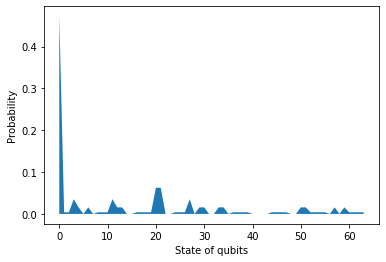

In [16]:
final_state = circuit.final_state_vector()
plt.fill_between(np.arange(len(final_state)),
                 np.abs(final_state)**2)
plt.xlabel("State of qubits")
plt.ylabel("Probability")
plt.show()

In reality, we can measure the state of qubits only. Each measurement will only produce one state. In order to eastimate the probability, we can do 100 repeitations and use frequency of showing 0 state as the approximation of the probability of state 0.

In [17]:
repetitions = 100
obs = s.run(circuit, repetitions=repetitions)
qubits_name = ','.join(str(i) for i in range(n))
times_zero_was_measured = len(obs.data[obs.data[qubits_name] == 0])
print(
    f"times zero state was measured from {repetitions} measurements:" +
    f"{times_zero_was_measured} - {float(times_zero_was_measured/repetitions)*100}%"
)
if float(times_zero_was_measured / repetitions) > 0.05:
    print("fs and gs is forrelated!")

times zero state was measured from 100 measurements:51 - 51.0%
fs and gs is forrelated!


Last, we can randomly draw the functions from either $\mathcal{U}$ or $\mathcal{F}$ set to evaluate the confusion matrix of the fourier checking algorithm. With the confusion matrix, you should be confident that quantum algorithm instead can solve the fourier checking in $O(1)$ time -- even though we need to measure 100 or 1000 times to evaluate the probability, it is irrelevant to the number of states or qubits.

In [20]:
res = pd.DataFrame()
repetitions = 100
for _ in range(1000):
    if np.random.rand() > 0.5:
        fs, gs, _, _ = draw_two_distribution_from_f_set(N)
        source = "F set"
    else:
        fs, gs, _, _ = draw_two_distribution_from_u_set(N)
        source = "U set"

    circuit = cirq.Circuit(fourier_checking_algorithm(qubits, fs, gs))
    obs = s.run(circuit, repetitions=repetitions)
    times_zero_was_measured = len(obs.data[obs.data[','.join(
        str(i) for i in range(n))] == 0])
    if times_zero_was_measured / repetitions > 0.05:
        res = res.append({
            "Source": source,
            "Decision": "accept",
            "Count": 1
        }, ignore_index=True)
    else:
        res = res.append({
            "Source": source,
            "Decision": "reject",
            "Count": 1
        }, ignore_index=True)
confusion = res.pivot_table(index="Source", columns="Decision", values="Count", aggfunc="sum")
# Translate the counts into percentage
confusion.div(confusion.sum(axis=1), axis=0).apply(lambda x: round(x, 4) * 100)

Decision,accept,reject
Source,,
F set,100.00,NaN
U set,6.05,93.95


# Query Complexity of Quantum Algorithm Versus the Classical one

After we present the quantum algorithm, it is time to look back to classical algorithm for comparison. It is not hard to give a classical algorithm that solves Fourier Checking using $O(\sqrt{N}) = O(2^{n/2})$ queries, which is similar as we did in the BPP section.

For some $K=\Theta(\sqrt{N})$, first choose sets $X=\{x_1,\ldots, x_K\}$ and $Y = \{y_1, \ldots, y_K\}$ of $n-$bit strings uniformly at random. Then query $f(x_i)$ and $g(y_i)$ for all $i \in [K]$. Finally, compute
$$
  Z := \sum_{i,j=1}^K f(x_i) (-1)^{x_i\cdot y_j} g(y_j)
$$
accept if $|Z|$ is greater than some cutoff $cK$, and reject otherwise. For suitable $K$ and $c$, one can show that this algorithm accepts a forrelated $\langle f, g \rangle$ pair with probability at least $2/3$. Comparing this with $O(1)$ complexity in quantum query, we can see an exponential speedup by using quantum computer.

<!-- Maybe we can find a better classical algorithm for forrelation problem, but it is proved that the lower bound on the classical query complexity is at least $\Omega\left(\sqrt[4]{N}\right) = \Omega\left(2^{n/4}\right)$. -->


# Further reading

The Forrelation problem was originally introduced in [1]. Later, a **$k$-fold Forrelation** problem was introduced in [2], which considered the forrelation between $k$ oracle functions. In that paper, it also improved the proof about the seperation of forrelation problem from $\Omega\left(\sqrt[4]{N}\right)$ to $\tilde{\Omega}\left(\sqrt{N}\right)$, which can not be further improved. Thus, resolving an open question of Buhrman et al., there is NO partial
Boolean function whose quantum query complexity is constant and whose randomized query complexity is linear. 

[1] *Scott Aaronson. BQP and the Polynomial Hierarchy. STOC ’10, page 141–150, New York, NY, USA, 2010.* [arXiv](https://arxiv.org/pdf/0910.4698.pdf)

[2] *Scott Aaronson and Andris Ambainis. Forrelation: A problem that optimally separates quantum
from classical computing. SIAM J. Comput., 47(3):982–1038, 2018.* [arXiv]( https://arxiv.org/pdf/1411.5729.pdf)